In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

from torch.optim import AdamW

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from safetensors.torch import save_file
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_train_dataset.csv"
TEST_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_dev_dataset.csv"
LABEL_COLUMN = "label"

MODEL_NAME = "bert-base-uncased"
MODEL_DIR = "bert_finetuned_custom"
EPOCHS = 2
SEED = 42
NUM_LABELS = 3
MAX_LEN = 512
BATCH_SIZE = 8
LEARNING_RATE = 5e-5
FREEZE_LAYERS = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)
print("Device:", device)
print(f"Using model: {MODEL_NAME}")


Device: cuda
Using model: bert-base-uncased


Labels mapped: ['cultural agnostic', 'cultural exclusive', 'cultural representative']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freezing first 3 layers of the BERT encoder...
Accessing layers via model.bert.encoder
Froze 48 parameters out of 192 in the encoder layers < 3.

Starting training...


Epoch 1/2: 100%|██████████| 782/782 [09:13<00:00,  1.41it/s, loss=0.133]


Epoch 1 - Avg Loss: 0.5669


Epoch 2/2: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s, loss=0.0146]


Epoch 2 - Avg Loss: 0.3733

Starting evaluation...


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s]



Classification Report:
                         precision    recall  f1-score   support

      cultural agnostic     0.8409    0.9487    0.8916       117
     cultural exclusive     0.6591    0.7632    0.7073        76
cultural representative     0.7500    0.5607    0.6417       107

               accuracy                         0.7633       300
              macro avg     0.7500    0.7575    0.7469       300
           weighted avg     0.7624    0.7633    0.7558       300

Plotting Confusion Matrix...


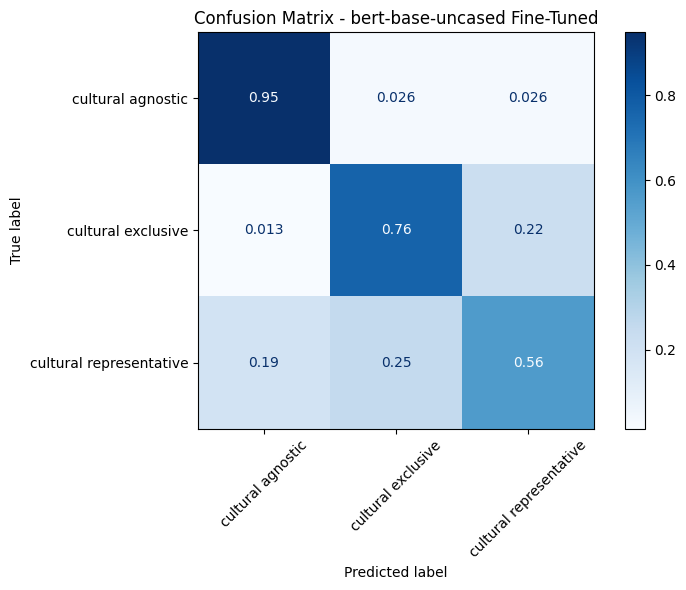


Saving model to bert_finetuned_custom...
Model and tokenizer saved to: bert_finetuned_custom


In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Fill NaN values in text-based columns
for df in [train_df, test_df]:
    for col in ['text', 'description', 'name', 'type', 'subcategory', 'category']:
        df[col] = df[col].fillna('')

# Concatenate relevant text fields
train_texts = (train_df['name'] + " - " + train_df['type'] + " - " + train_df['subcategory'] + " - " +
               train_df['category'] + " - " + train_df['description'] + " - " + train_df['text']).tolist()
test_texts = (test_df['name'] + " - " + test_df['type'] + " - " + test_df['subcategory'] + " - " +
              test_df['category'] + " - " + test_df['description'] + " - " + test_df['text']).tolist()

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df[LABEL_COLUMN])
test_labels = label_encoder.transform(test_df[LABEL_COLUMN])
print(f"Labels mapped: {list(label_encoder.classes_)}")


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")


train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], torch.tensor(train_labels))
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

print(f"Freezing first {FREEZE_LAYERS} layers of the BERT encoder...")
try:

    bert_encoder = model.bert.encoder
    print("Accessing layers via model.bert.encoder")
except AttributeError:

    bert_encoder = model.base_model.encoder
    print("Accessing layers via model.base_model.encoder")

frozen_count = 0
total_params = 0
for name, param in bert_encoder.named_parameters():
    total_params +=1
    if name.startswith("layer"):
        try:
            layer_num = int(name.split('.')[1])
            if layer_num < FREEZE_LAYERS:
                param.requires_grad = False
                frozen_count +=1
                # print(f"Froze layer {layer_num}: {name}") # Uncomment for detailed freezing log
        except (IndexError, ValueError):

             pass
print(f"Froze {frozen_count} parameters out of {total_params} in the encoder layers < {FREEZE_LAYERS}.")



model.to(device)
# Filter parameters to pass only trainable ones to the optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

print("\nStarting training...")
for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    total_loss = 0
    # Setup progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)
    for batch in loop:
        # Move batch to device
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calculate loss
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update progress bar
        loop.set_postfix(loss=loss.item())

    # Print average loss for the epoch
    print(f"Epoch {epoch+1} - Avg Loss: {total_loss / len(train_loader):.4f}")

# === Evaluation ===
print("\nStarting evaluation...")
model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []

# Disable gradient calculations for evaluation
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"): # Add progress bar for evaluation
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4, zero_division=0))

# Plot confusion matrix
print("Plotting Confusion Matrix...")
cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title(f"Confusion Matrix - {MODEL_NAME} Fine-Tuned")
plt.grid(False)
plt.tight_layout()
plt.show()


print(f"\nSaving model to {MODEL_DIR}...")
os.makedirs(MODEL_DIR, exist_ok=True)

model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

print(f"Model and tokenizer saved to: {MODEL_DIR}")